In [1]:
import glworia.amplification_factor
import glworia.lens_functions
from glworia.amplification_factor import *
from glworia.lens_functions import *

In [2]:
import numpy as np

In [3]:
from importlib import reload

In [4]:
from tqdm import tqdm

In [5]:
reload(glworia.amplification_factor)
reload(glworia.lens_functions)
from glworia.amplification_factor import *
from glworia.lens_functions import *

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

In [7]:
import matplotlib.pyplot as plt

In [8]:
T_funcs, helper_funcs = amplification_computation_prep(Psi_NFW)

In [9]:
kappa_arr = jnp.linspace(0.1, 3., num = 101)
y_arr = jnp.linspace(1., 3., num = 101)

2023-05-15 18:23:37.634152: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
kappa_arr

Array([0.1  , 0.129, 0.158, 0.187, 0.216, 0.245, 0.274, 0.303, 0.332,
       0.361, 0.39 , 0.419, 0.448, 0.477, 0.506, 0.535, 0.564, 0.593,
       0.622, 0.651, 0.68 , 0.709, 0.738, 0.767, 0.796, 0.825, 0.854,
       0.883, 0.912, 0.941, 0.97 , 0.999, 1.028, 1.057, 1.086, 1.115,
       1.144, 1.173, 1.202, 1.231, 1.26 , 1.289, 1.318, 1.347, 1.376,
       1.405, 1.434, 1.463, 1.492, 1.521, 1.55 , 1.579, 1.608, 1.637,
       1.666, 1.695, 1.724, 1.753, 1.782, 1.811, 1.84 , 1.869, 1.898,
       1.927, 1.956, 1.985, 2.014, 2.043, 2.072, 2.101, 2.13 , 2.159,
       2.188, 2.217, 2.246, 2.275, 2.304, 2.333, 2.362, 2.391, 2.42 ,
       2.449, 2.478, 2.507, 2.536, 2.565, 2.594, 2.623, 2.652, 2.681,
       2.71 , 2.739, 2.768, 2.797, 2.826, 2.855, 2.884, 2.913, 2.942,
       2.971, 3.   ], dtype=float64)

In [11]:
settings = {'T0_max': 30,
            'crit_bisect_x_low': -100,
            'crit_bisect_x_high': 100,
            'long_num':5000,
            'short_num':1000}

In [12]:
T_len = settings['long_num'] + 2*settings['short_num']

In [13]:
results = np.zeros((len(kappa_arr), len(y_arr), T_len))

In [14]:
for i, kappa in tqdm(enumerate(kappa_arr)):
    for j, y0 in enumerate(y_arr):
        y = jnp.array([y0, 0])
        lens_params = jnp.array([kappa])
        contour_integral = amplification_computation(T_funcs, helper_funcs, y, lens_params, **settings)
        results[i, j, :] = np.array(contour_integral.u_sum)
        print(i, j)

0it [00:00, ?it/s]

In [20]:
import pickle


In [21]:
# with open('./data/test2.pickle', 'wb') as f:
#     pickle.dump(results, f)

In [22]:
with open('./data/test2.pickle', 'rb') as f:
    results = pickle.load(f)

In [57]:
@partial(jnp.vectorize, signature = '(n)->(n)')
def normalize(x):
    return x/jnp.linalg.norm(x)

@partial(jnp.vectorize, signature = '(n),(n)->()')
def vec_dot(x, bases):
    return jnp.inner(x, bases)

@partial(jnp.vectorize, signature = '(m,n),(a,n)->(m,a)')
def vec_dot_2D(x, bases):
    return jnp.inner(x, bases)

@partial(jnp.vectorize, signature = '(n),(m,n)->(n)')
def projection(x, bases):
    coeffs = vec_dot(x, bases)
    return jnp.einsum('i,ij->j', coeffs, bases)

@partial(jnp.vectorize, signature = '(n),(m,n)->(n)')
def residue_raw(x, bases):
    return x - projection(x, bases)

def residue(x, bases):
    bases = jnp.atleast_2d(bases)
    return residue_raw(x, bases)

@partial(jnp.vectorize, signature = '(n)->()')
def norm(x):
    return jnp.linalg.norm(x)

vec_cumsum = jnp.vectorize(jnp.cumsum, signature = '(n)->(n)')

In [58]:
vec_dot_mat = jnp.vectorize(jnp.inner, signature = '(a,n),(b,n)->(a,b)')

def Gramian(bases):
    return vec_dot_mat(bases, bases)

In [59]:
def GS_step(i, val):
    u = val[0]
    bases = val[1]
    basis = bases[i]
    u_prime = residue(u, basis)
    return [u_prime, bases]

In [60]:
def GS(x, bases):
    init_val = [x, bases]
    val = jax.lax.fori_loop(0, len(bases), GS_step, init_val)
    return normalize(val[0])

In [61]:
results = jnp.array(results)

In [62]:
@partial(jnp.vectorize, signature = '(n)->(n)')
def rescale_to_peak(x):
    max_indx = jnp.argmax(x)
    T_new = jnp.linspace(0, max_indx/(len(x)-1), len(x))
    T_old = jnp.linspace(0, 1, len(x))
    x_new = jnp.interp(T_new, T_old, x)
    return x_new

@partial(jnp.vectorize, signature = '(n)->(n)')
def rescale_after_peak(x):
    max_indx = jnp.argmax(x)
    T_new = jnp.linspace(max_indx/(len(x)-1), 1, len(x))
    T_old = jnp.linspace(0, 1, len(x))
    x_new = jnp.interp(T_new, T_old, x)
    return x_new

In [226]:
result_flat = results.reshape((-1, results.shape[-1]))
# training_set = rescale_to_peak(result_flat)
training_set = normalize(result_flat - 1)

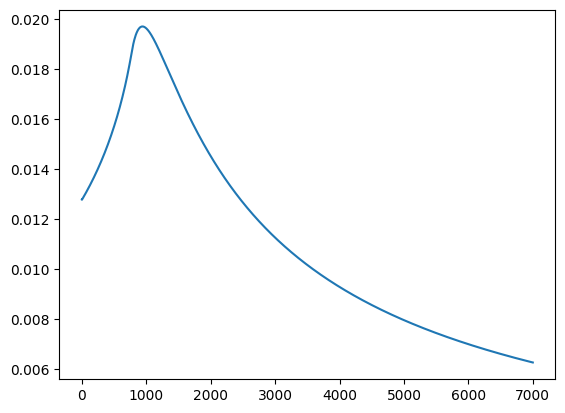

In [227]:
plt.plot((training_set[4000]))

In [76]:
iter = 0
sig = 1
indx = len(training_set)-100
indx_list = [indx]
sig_list = [sig]
bases = jnp.atleast_2d(normalize(training_set[indx]))
while iter < 10:
    iter += 1
    sig_all = norm(residue(training_set, bases))
    max_sig_indx = jnp.argmax(sig_all)
    sig = sig_all[max_sig_indx]
    e_new = GS(training_set[max_sig_indx], bases)
    bases = jnp.vstack((bases, e_new))
    indx_list.append(max_sig_indx)
    print(sig)
    sig_list.append(sig)

0.04710043220738874
0.003331189400434812
0.0006087126019585675
0.0002762716214952082
8.76456128337259e-05
4.387367816578586e-05
2.7707700401607186e-05
1.969768162082416e-05
1.6518230178740167e-05
1.4945992336696413e-05


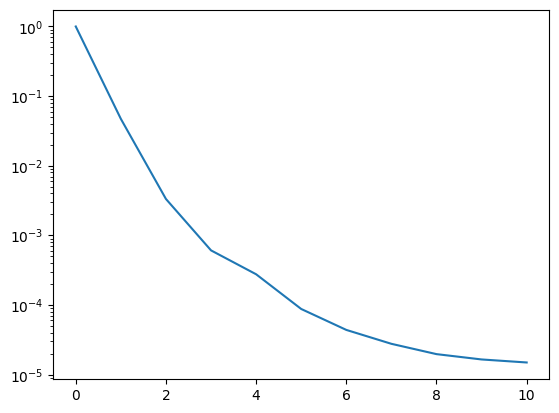

In [77]:
plt.semilogy(sig_list)

In [78]:
kappa_node = jnp.array(indx_list)//len(y_arr)
y_node = jnp.array(indx_list)%len(y_arr)

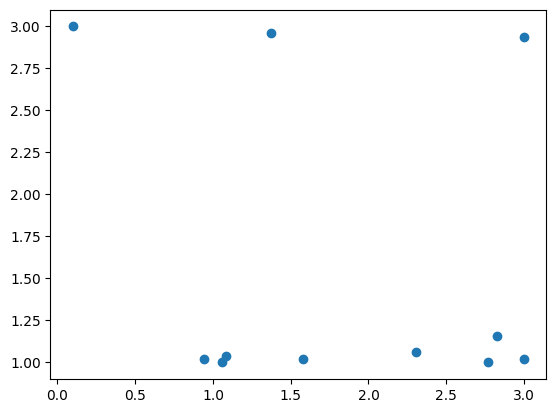

In [79]:
plt.scatter(kappa_arr[kappa_node], y_arr[y_node])

In [80]:
coeffs = vec_dot_2D(training_set, bases)

In [88]:
K, Y = jnp.meshgrid(kappa_arr, y_arr)
C = jnp.reshape(coeffs, (len(kappa_arr), len(y_arr), -1))

<a list of 21 text.Text objects>

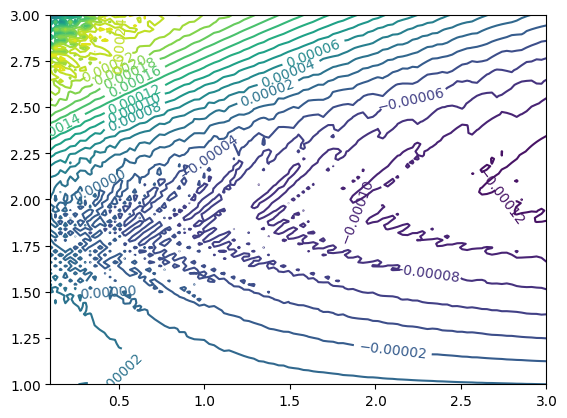

In [98]:
indx = 4

fig, ax = plt.subplots()
# contour plot with color bar and labels
CS = ax.contour(K, Y, C[:,:,indx], levels = 20)
ax.clabel(CS, inline=1, fontsize=10)

In [232]:
T = training_set[0]

In [233]:
def chev_poly():
    pass

In [309]:
def chev_points(N):
    return jnp.cos(jnp.pi*(jnp.arange(N)+0.5)/N)    

def chev_poly(x, n):
    return jnp.cos(n*jnp.arccos(x))

chev_poly_1D = jnp.vectorize(chev_poly, signature = '(n),()->(n)')
chev_poly_2D = jnp.vectorize(chev_poly, signature = '(n,a),(m,b)->(m,n)')

In [310]:
vdot_map_2 = jnp.vectorize(jnp.inner, signature = '(n),(m,n)->(m)')

In [324]:
def chev_interp(y_raw, N):
    x_raw = jnp.linspace(-1, 1, len(y_raw))
    x = chev_points(N)
    y = jnp.interp(x, x_raw, y_raw)
    return y

@partial(jnp.vectorize, signature = '(n),(),(m)->(m)')
def DCT(y_raw, N, m):
    x_raw = jnp.linspace(-1, 1, len(y_raw))
    x = chev_points(N)
    y = jnp.interp(x, x_raw, y_raw)
    T_m = chev_poly_1D(x, m)
    a_m_raw = vdot_map_2(y, T_m)
    p_m = jnp.heaviside(m, 0) + 1
    return p_m/N*a_m_raw

def iDCT(a_m, N):
    x = chev_points(N)
    M = jnp.arange(N)
    T_m = chev_poly_1D(x,M)
    y = vdot_map_2(a_m, T_m)
    return y, T_m

In [325]:
N = 100
M = jnp.arange(N)
x = chev_points(N)
a = DCT(T, N, M)

In [326]:
x = chev_points(N)
M = jnp.arange(N)
T_m = chev_poly_1D(x,M)

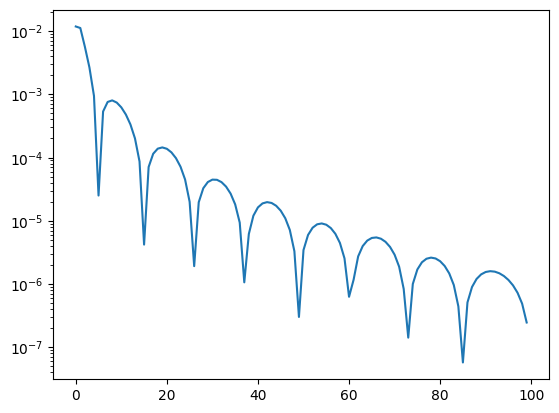

In [327]:
plt.semilogy(np.abs(a))

In [328]:
inv_T, T_m = iDCT(a, N)

In [329]:
T_m

Array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.99987663,  0.99888987,  0.99691733, ..., -0.99691733,
        -0.99888987, -0.99987663],
       [ 0.99950656,  0.99556196,  0.98768834, ...,  0.98768834,
         0.99556196,  0.99950656],
       ...,
       [ 0.04710645, -0.14090123,  0.23344536, ..., -0.23344536,
         0.14090123, -0.04710645],
       [ 0.03141076, -0.09410831,  0.15643447, ...,  0.15643447,
        -0.09410831,  0.03141076],
       [ 0.01570732, -0.04710645,  0.0784591 , ..., -0.0784591 ,
         0.04710645, -0.01570732]], dtype=float64, weak_type=True)

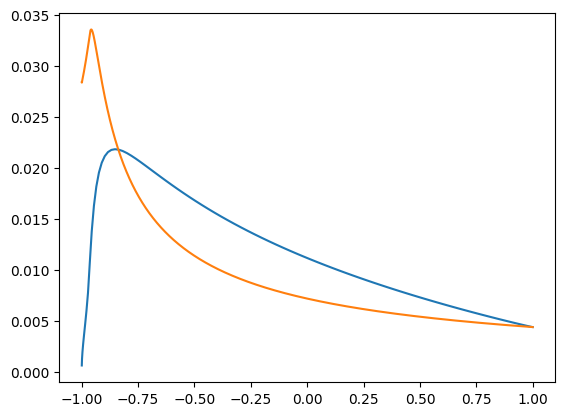

In [330]:
plt.plot(x, inv_T)
plt.plot(jnp.linspace(-1, 1, len(T)), T)

In [108]:
chev_interp(T, 10)

Array([0.01196977, 0.01196948, 0.0119672 , 0.01196129, 0.01195483,
       0.0119486 , 0.01194314, 0.01193879, 0.0119358 , 0.01193431],      dtype=float64)

In [102]:
chev_points(10)

Array([ 0.98768834,  0.89100652,  0.70710678,  0.4539905 ,  0.15643447,
       -0.15643447, -0.4539905 , -0.70710678, -0.89100652, -0.98768834],      dtype=float64, weak_type=True)

In [82]:
for c_arr in coeffs.T:
    points = jnp.vstack((K.ravel(), Y.ravel())).T
    h_interp = griddata(points, hs, (3.0, 1.0), method='linear')

(10201, 11)

In [152]:
def V_mat(bases, t_nodes):
    return bases[:, t_nodes].T

@partial(jnp.vectorize, signature = '(m,n),(m)->(n,m)')
def B_x(bases, t_nodes):
    V = V_mat(bases, t_nodes)
    inv_V = jnp.linalg.inv(V)
    return jnp.einsum('ik,ij->kj', bases, inv_V)

def I_n(x, bases, t_nodes):
    j = jnp.arange(len(bases))
    B = B_x(bases, t_nodes)
    h = x[t_nodes]
    return jnp.einsum('ij,j->i', B, h)


In [153]:
t_nodes = jnp.array([jnp.argmax(jnp.abs(bases[0]))])
for i in range(1, len(bases)):
    bases_i = jnp.atleast_2d(bases[:i])
    I = I_n(bases[i], bases_i, t_nodes)
    r = jnp.abs(bases[i] - I)
    t_node = jnp.argmax(r)
    print(r[t_node])
    t_nodes = jnp.append(t_nodes, t_node)

0.04140361817164202
0.03015449568948437
0.04065417684896918
0.04956807821127146
0.05974550779779784


In [154]:
B_full = B_x(bases, t_nodes)

In [155]:
t_nodes

Array([6999, 5619, 6171, 3225,   12, 5951], dtype=int64)

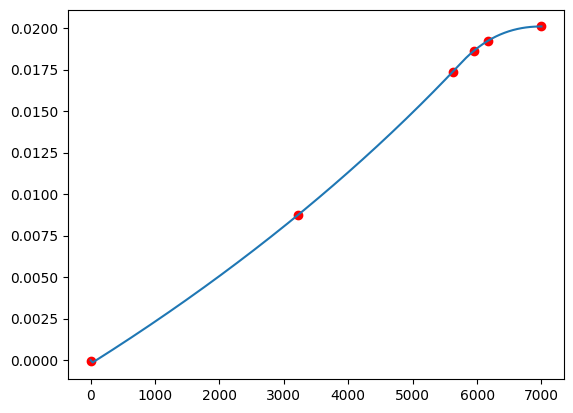

In [156]:
i = 10
plt.plot(training_set[i, :])
plt.scatter(t_nodes, training_set[i, t_nodes], c = 'r')

In [157]:
results[:,:,t_nodes[0]]

Array([[1.00256329, 1.0025629 , 1.00256251, ..., 1.00248078, 1.00247942,
        1.00247804],
       [1.00330272, 1.00330224, 1.00330174, ..., 1.00319781, 1.00319607,
        1.00319431],
       [1.00404148, 1.00404091, 1.00404032, ..., 1.00391486, 1.00391275,
        1.00391061],
       ...,
       [1.07218003, 1.07220235, 1.07222446, ..., 1.07312821, 1.07312169,
        1.07311475],
       [1.07286421, 1.07288707, 1.07290973, ..., 1.07385627, 1.07385005,
        1.07384342],
       [1.07354793, 1.07357134, 1.07359454, ..., 1.07458453, 1.07457864,
        1.07457232]], dtype=float64)

In [159]:
indx = 0
hs = results[:,:,t_nodes[indx]].ravel()
points = jnp.vstack((K.ravel(), Y.ravel())).T

In [160]:
from scipy.interpolate import griddata

In [161]:
h_at_nodes = []
for t_node in t_nodes:
    hs = results[:,:,t_node].ravel()
    points = jnp.vstack((K.ravel(), Y.ravel())).T
    h_interp = griddata(points, hs, (3.0, 1.0), method='linear')
    h_at_nodes.append(h_interp)


In [162]:
h_at_nodes = jnp.array(h_at_nodes)

In [163]:
h_full_interp = jnp.einsum('ij,j->i', B_full, h_at_nodes)

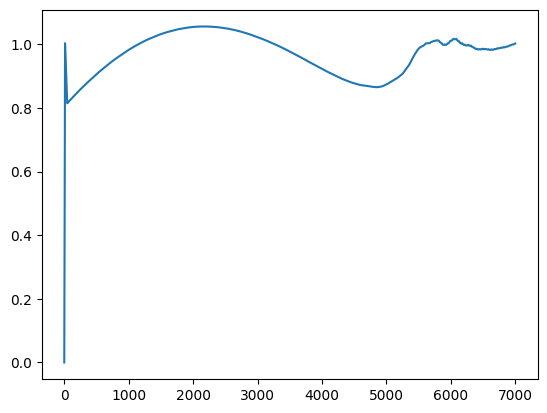

In [164]:
plt.plot(h_full_interp)

In [100]:
bases = normalize(training_set[1:5])

In [101]:
bases.shape

(4, 7000)

In [103]:
norm(projection(training_set, bases))

Array([336.58593693, 336.51801692, 336.45016893, 336.38289548,
       336.31651858, 336.25124593, 336.18721103, 336.12449691,
       336.06315342, 336.00320789, 335.94467236, 342.15010185,
       341.88227476, 341.61569033, 341.35197834, 341.09216491,
       340.83690693, 340.58662513, 340.34158773, 340.10193803,
       339.86774949, 339.63908195, 347.70414628, 347.23293606,
       346.76530582, 346.3035169 , 345.84909855, 345.40295997,
       344.96572205, 344.53772693, 344.11918772, 343.71020222,
       343.31078512, 353.24593565, 352.56879627, 351.89833083,
       351.2372686 , 350.58732097, 349.94957899, 349.32476292,
       348.71325352, 348.11524684, 347.53087431, 346.96012684,
       358.77390787, 357.88898705, 357.01444558, 356.15315086,
       355.30694231, 354.47700234, 353.66405333, 352.86846041,
       352.0904398 , 351.33007083, 350.58730728, 364.28699405,
       363.19300382, 362.1134334 , 361.05119162, 360.00815957,
       358.98550416, 357.9838751 , 357.00367781, 356.04